# Packages

In [1]:
## import packages
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import math
import operator

C:\Users\Max\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data

In [2]:
# read in data
train = pd.read_csv('training_set.csv',encoding = 'unicode_escape', parse_dates=True)

In [3]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


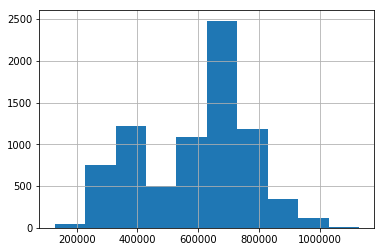

In [4]:
train['Engagements'].hist()

## Feature Engineering

Feature engineering was performed based on two categories of features:
#### 1. Temporal
We felt that various levels of time based features could help predict engagement such as hour of the day, weekday, and month.  Intuitively, we expect that evening and night time hours yield higher engagement levels as this is when most games are played.  Additionally, weekend games (including Friday) would lead to higher engagement as this is when more fans are able to tune in and more games are nationally televised.  Finally, we expect that posts during the season would lead to higher engagement than posts during the end of the season and the offseason.
#### 2. Text (Description)
The description of the post allow for many features to be derived.  Firstly, the length of the caption could correlate with engagement, as posts with longer captions might naturally be about more exciting games/players/highlights.  In terms of the actual contents of the text, posts that are related to popular players and teams are expected to drive engagement.  We looked at top merchandise sales and instagram following by player and team which allowed us to categorize a player as popular or not, and allowed us to bucket teams into increments of 5 which helped differentiate posts in terms of engagement.  To increase the strength of our popular player and team categories, we ran TF-IDF analysis on the captions to identify players and teams with high engagement shares in the corpus of captions. We also looked at which posts involved a hashtag (#) or were posted at another account (@), as signals could indicate that the posts were about a popular topic/event/team/player and instagram users would be able to find these posts through other searches.  Finally, we felt that posts about games on national TV or event such as the playoffs ors draft would lead to higher engagement.  

In [5]:
# create time based features
def time_features(dataset):
    
    # convert date to datetime
    dataset['Created'] = pd.to_datetime(dataset['Created'])

    # create date based fields
    dataset['weekday'] = dataset['Created'].apply(lambda x: x.weekday())
    dataset['weekend'] = np.where(dataset['weekday'] >= 4,'Y','N')
    dataset['hour'] = dataset['Created'].dt.hour
    dataset['timeOfDay'] = np.where((dataset['hour'] >= 2) & (dataset['hour'] <=11) ,'Morning',
                              np.where((dataset['hour'] >= 12) & (dataset['hour'] <=15),'Afternoon', np.where(
                                  (dataset['hour'] >= 16) & (dataset['hour'] <=19),'Evening','Night')))
    dataset['mon'] = dataset['Created'].dt.month
    dataset['offseason'] = np.where((dataset['mon'] >= 7) & (dataset['mon'] <=9) ,'Y','N')
    
    return dataset

In [6]:
def lower_description(dataset):
    
    # create lowercase caption for text based features
    dataset['DescLower'] = dataset['Description'].str.lower()
    
    return dataset

In [7]:
def remove_special_char(s):
    '''This function use regex to replace special characters in a string
    '''
    try:
        rst = re.sub('_','',re.sub('[^\w\s]','',s))
        rst = re.sub('\s+',' ',rst)
    except:
        print(s)
        if math.isnan(float(s)):
            return ''
    return rst.strip()

def get_doc(sents):
    '''This function takes each desctiption and creates a dict of {doc_id,length}
    '''
    doc_info = []
    i = 0
    for sent in sents:
        i+=1
        cnt = count_words(sent)
        temp = {'doc_id':i,'doc_length':cnt}
        doc_info.append(temp)
    return doc_info

def count_words(sent):
    '''This function count how many words are in one description
    '''
    cnt = 0
    words = word_tokenize(sent)
    for word in words:
        cnt += 1
    return cnt

def create_freq_dict(sents):
    '''This function takes all description and create {doc_id,{word:word_count...}}
    '''
    i = 0
    freqDict_list = []
    for sent in sents:
        i+=1
        freq_dict = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            if word in freq_dict:
                freq_dict[word]+=1
            else:
                freq_dict[word]=1
            tmp = {'doc_id':i, 'freq_dict':freq_dict}
        freqDict_list.append(tmp)
    return freqDict_list

def calTF(doc_info,freqDict_list):
    '''This funciton calculates term frequency
    '''
    tf_scores = []
    for tmpdict in freqDict_list:
        myid = tmpdict['doc_id']
        for k in tmpdict['freq_dict']:
            tmp = {'doc_id':myid,
                  'TF_score': tmpdict['freq_dict'][k]/doc_info[myid-1]['doc_length'],
                  'key':k}
            tf_scores.append(tmp)
    return tf_scores

def calIDF(doc_info,freqDict_list):
    '''This funciton calculates Inverse document frequency
    '''
    idf_scores = []
    cnt = 0
    for tmpdict in freqDict_list:
        cnt+=1
        for k in tmpdict['freq_dict'].keys():
            count = sum([k in tmpdict['freq_dict'] for tmpdict in freqDict_list])
            tmp = {'doc_id':cnt,
                  'IDF_score': math.log(len(doc_info)/count),
                  'key':k}
            idf_scores.append(tmp)
    return idf_scores

def calTFIDF (tf_scores,idf_scores):
    tfidf_Scores = []
    for j in idf_scores:
        for i in tf_scores:
            if j['key'] == i['key'] and j['doc_id'] == i['doc_id']:
                temp = {
                    'doc_id':j['doc_id'],
                    'tfidf_score': j['IDF_score']*i['TF_score'],
                    'key':i['key']
                }
                break
        tfidf_Scores.append(temp)
    return tfidf_Scores

In [8]:
def engagement_shares(dataset):
    '''This function calculates each word's engagement shares based on weighted value of their TFIDF values
    '''
    
    post_ls = train.DescLower.values
    post_ls = [remove_special_char(s) for s in post_ls]
    doc_info = get_doc(post_ls)
    freqDict_list = create_freq_dict(post_ls)
    tfidf_scores = calTFIDF(calTF(doc_info,freqDict_list),calIDF(doc_info,freqDict_list))
    
    word_ls = [x['key'] for x in tfidf_scores]
    score_ls = [x['tfidf_score'] for x in tfidf_scores]
    word_set = set([x['key'] for x in tfidf_scores])

    word_dict = {}
    for word in word_set:
        indices = [i for i,x in enumerate(tfidf_scores) if x['key'] == word]
        scores = [score_ls[x] for x in indices]
        word_dict[word] = sum(scores)/len(scores)

    word_engage = {}
    for word in word_set:
        word_engage[word] = 0

    for i,sent in enumerate(train.DescLower.values):
        this_words = word_tokenize(remove_special_char(sent))
        this_engage = train.Engagements.values[i]
        this_scores = []
        for word in this_words:
            if word in word_dict:
                this_scores.append(word_dict[word])
            else:
                this_scores.append(0)
        this_scores = np.array(this_scores) # tf idf values for each word
        this_scores = this_scores/sum(this_scores) # % of its tfidf values
    
        for j,word in enumerate(this_words):
            if word in word_engage:
                word_engage[word] += this_engage*this_scores[j]
                
    sorted_shares = sorted(word_engage.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_shares

In [9]:
# create the text based features
def description_features(dataset):
    
    ## create caption based fields
    dataset['CapLength'] = dataset['Description'].str.len().fillna(0) # length of caption
    
    # list of most popular players based on engagment shares - calculated via tf-idf
    popPlayerRegex = 'lebron|kingjames|curry|stephencurry|giannis|kyrie|embiid|harden|westbrook|russwest44|durant|easymoneysniper|porzingis|kporzee|simmons|bensimmons|dwyane|kawhi|spidadmitchell|dwyanewade|cp3'
    dataset['popPlayer'] = dataset['DescLower'].str.contains(popPlayerRegex,regex=True)*1
    
    # list of most popular teams based on instagram followings
    #popTeamRegex = 'lakers|warriors|celtics|knicks|sixers|bucks|thunder|rockets|raptors|cavs|bulls'
    #top10Team = 'warriors|cavs|lakers|chicagobulls|okcthunder|miamiheat|celtics|houstonrockets|spurs|laclippers'
    top5Team = 'warriors|cavs|lakers|chicagobulls|okcthunder'
    top5to10Team = 'miamiheat|celtics|houstonrockets|spurs|laclippers'
    top10to15Team = 'nyknicks|raptors|pacers|sixers|timberwolves'
    top15to20Team = 'bucks|trailblazers|pelicansnba|washwizards|hornets'
    top20to25Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings'
    top25to30Team = 'detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
    #top20Team = 'nyknicks|raptors|pacers|sixers|timberwolves|bucks|trailblazers|pelicansnba|washwizards|hornets'
    #top30Team = 'brooklynnets|dallasmavs|atlhawks|suns|sacramentokings|detroitpistons|orlandomagic|nuggets|utahjazz|memgrizz'
    #dataset['popTeam'] = dataset['DescLower'].str.contains(popTeamRegex,regex=True)*1
    #dataset['top10Team'] = dataset['DescLower'].str.contains(top10Team,regex=True)*1
    #dataset['top20Team'] = dataset['DescLower'].str.contains(top20Team,regex=True)*1
    #dataset['top30Team'] = dataset['DescLower'].str.contains(top30Team,regex=True)*1
    dataset['top5Team'] = dataset['DescLower'].str.contains(top5Team,regex=True)*1
    dataset['top5to10Team'] = dataset['DescLower'].str.contains(top5to10Team,regex=True)*1
    dataset['top10to15Team'] = dataset['DescLower'].str.contains(top10to15Team,regex=True)*1
    dataset['top15to20Team'] = dataset['DescLower'].str.contains(top15to20Team,regex=True)*1
    dataset['top20to25Team'] = dataset['DescLower'].str.contains(top20to25Team,regex=True)*1
    dataset['top25to30Team'] = dataset['DescLower'].str.contains(top25to30Team,regex=True)*1
    
    # post is tagged at another insta handle
    dataset['at'] = dataset['DescLower'].str.contains('@',regex=True)*1
    
    # post contains a hashtag
    dataset['hash'] = dataset['DescLower'].str.contains('#',regex=True)*1

    # tries to capture games on national tv
    natlTvRegex = 'tnt|espn|abc|nbatv'
    dataset['natlTV'] = dataset['DescLower'].str.contains(natlTvRegex,regex=True)*1

    # posts about an even such as allstar game or playoffs or draft - supported by engagment shares
    dataset['event'] = dataset['DescLower'].str.contains('allstar|all-star|finals|playoff|draft|slamdunk|thisiswhyweplay|phantomcam|kiatipoff|nbaontnt|nbapreseason|nbaonabc|nbaplayoffs|nbafinals',regex=True)*1
    
    return dataset

In [10]:
def create_features(dataset):
    
    dataset = time_features(dataset)
    dataset = description_features(dataset)
    
    return dataset

In [11]:
# lower case description for text analytics
train = lower_description(train)

In [14]:
# look at engagment shares and adjust the description_features function as needed
shares = engagement_shares(train)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [16]:
shares

[('the', 61405203.52366523),
 ('for', 45341849.53704449),
 ('to', 39529813.78681452),
 ('in', 37728429.44991266),
 ('kingjames', 37382212.91725452),
 ('it', 34449052.74745733),
 ('with', 28854737.734769642),
 ('up', 27278453.305204228),
 ('on', 25173868.21858193),
 ('thisiswhyweplay', 24581250.009123094),
 ('of', 22656988.64735945),
 ('slam', 21870911.41364487),
 ('from', 20701102.05137535),
 ('nbaontnt', 19937731.026949573),
 ('nbapreseason', 19554866.220570587),
 ('nbaonabc', 19369848.820956256),
 ('nbaplayoffs', 19041929.77980225),
 ('stephencurry30', 18892793.52458515),
 ('a', 18841907.512596976),
 ('jharden13', 18836048.658198666),
 ('transition', 18711505.00964727),
 ('giannisan34', 18543649.860812314),
 ('action', 18517924.672773782),
 ('kyrieirving', 17771312.072909843),
 ('off', 17591915.7657081),
 ('x', 17522079.227170628),
 ('his', 17114334.039742626),
 ('back', 17102039.411699913),
 ('espn', 16880432.09214757),
 ('nbaallstar', 16429446.859087087),
 ('phantomcam', 16398255.8

In [12]:
# create features
train = create_features(train)

C:\Users\Max\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\Max\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [13]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description,DescLower,weekday,weekend,hour,timeOfDay,...,top5Team,top5to10Team,top10to15Team,top15to20Team,top20to25Team,top25to30Team,at,hash,natlTV,event
0,502093,36984682,2019-05-21 23:30:51,Video,The @raptors bench trio of @sergeibaka @norman...,the @raptors bench trio of @sergeibaka @norman...,1,N,23,Night,...,0,0,1,0,0,0,1,0,0,0
1,603380,36984682,2019-05-21 22:53:33,Video,@kyle_lowry7 pulls from deep for the @raptors ...,@kyle_lowry7 pulls from deep for the @raptors ...,1,N,22,Night,...,0,0,1,0,0,0,1,0,1,0
2,603380,36984682,2019-05-21 22:19:58,Video,@k_mid22 with some english on the @bucks dime!,@k_mid22 with some english on the @bucks dime!,1,N,22,Night,...,0,0,0,1,0,0,1,0,0,0
3,725100,36984682,2019-05-21 22:02:41,Video,Kawhi punches it home with the left on TNT!,kawhi punches it home with the left on tnt!,1,N,22,Night,...,0,0,0,0,0,0,0,0,1,0
4,661446,36984682,2019-05-21 20:47:49,Video,@giannis_an34 goes baseline early to rock the ...,@giannis_an34 goes baseline early to rock the ...,1,N,20,Night,...,0,0,0,0,0,0,1,0,1,0


# Feature Selection & EDA

### We plotted engagements across the time based dimensions to show distinctions in Engagements depending on time of day, day of week, and month

In [14]:
## weekend posts show higher average engagement
print("Average number of Engagements by Weekend (Y) vs Weekday (N)\n")
print(train.groupby(['weekend']).agg({'Engagements':'mean'}))

Average number of Engagements by Weekend (Y) vs Weekday (N)

           Engagements
weekend               
N        585368.861007
Y        600874.161012


Text(0,0.5,'Mean # Engagements')

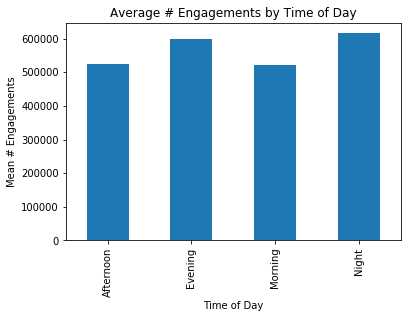

In [15]:
# evening and night time posts show higher engagement than morning and afternoon
train.groupby(['timeOfDay']).agg({'Engagements':'mean'}).plot.bar(title='Average # Engagements by Time of Day',legend=False)
plt.xlabel('Time of Day')
plt.ylabel('Mean # Engagements')

Text(0,0.5,'Mean # Engagements')

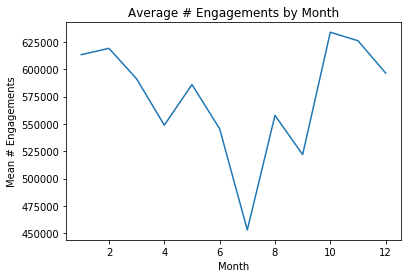

In [16]:
# Engagements are especially low during the offseason, and higher in the first half of the regular season (Oct - Feb)
train.groupby(['mon']).agg({'Engagements':'mean'}).plot(title='Average # Engagements by Month',legend=False)
plt.xlabel('Month')
plt.ylabel('Mean # Engagements')

### We compared engagement across different categories for the text based features to see which features might show differences in engagement

In [17]:
print("Correlation between Length of Caption and Engagements\n")
print(np.corrcoef(train.CapLength,train.Engagements))
print("\nAverage Level of Engagement between posts containing a popular player (1) vs not (0)\n")
print(train.groupby(['popPlayer']).agg({'Engagements':'mean'}))
print("\nAverage Level of Engagement between posts @ another account (1) vs not (0)\n")
print(train.groupby(['at']).agg({'Engagements':'mean'}))
print("\nAverage Level of Engagement between posts containing a hashtag (1) vs not (0)\n")
print(train.groupby(['hash']).agg({'Engagements':'mean'}))
print("\nAverage Level of Engagement between posts for games on national TV (1) vs not (0)\n")
print(train.groupby(['natlTV']).agg({'Engagements':'mean'}))
print("\nAverage Level of Engagement between posts about an NBA event, e.g. all start game (1) vs not (0)\n")
print(train.groupby(['event']).agg({'Engagements':'mean'}))

Correlation between Length of Caption and Engagements

[[ 1.         -0.27327902]
 [-0.27327902  1.        ]]

Average Level of Engagement between posts containing a popular player (1) vs not (0)

             Engagements
popPlayer               
0          564299.184012
1          663392.681529

Average Level of Engagement between posts @ another account (1) vs not (0)

      Engagements
at               
0   560877.332230
1   600027.100304

Average Level of Engagement between posts containing a hashtag (1) vs not (0)

        Engagements
hash               
0     618623.369652
1     564144.918542

Average Level of Engagement between posts for games on national TV (1) vs not (0)

          Engagements
natlTV               
0       590195.600509
1       601887.503770

Average Level of Engagement between posts about an NBA event, e.g. all start game (1) vs not (0)

         Engagements
event               
0      598504.764899
1      580057.489677


/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


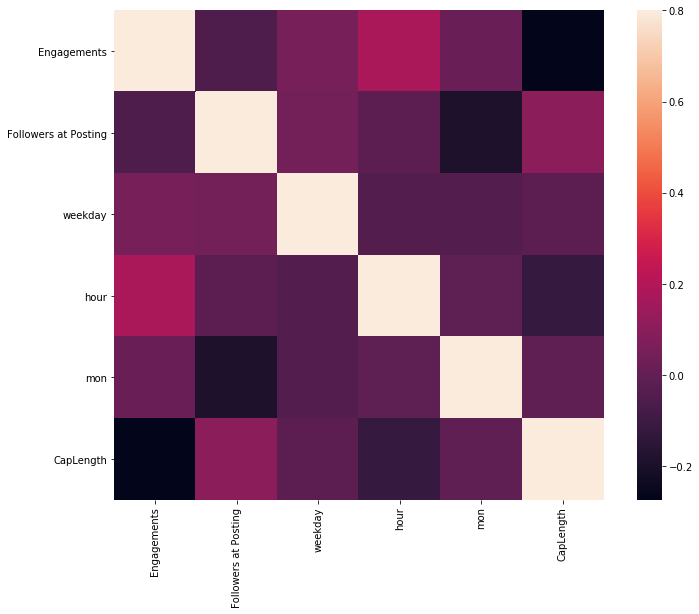

In [13]:
import seaborn as sns
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

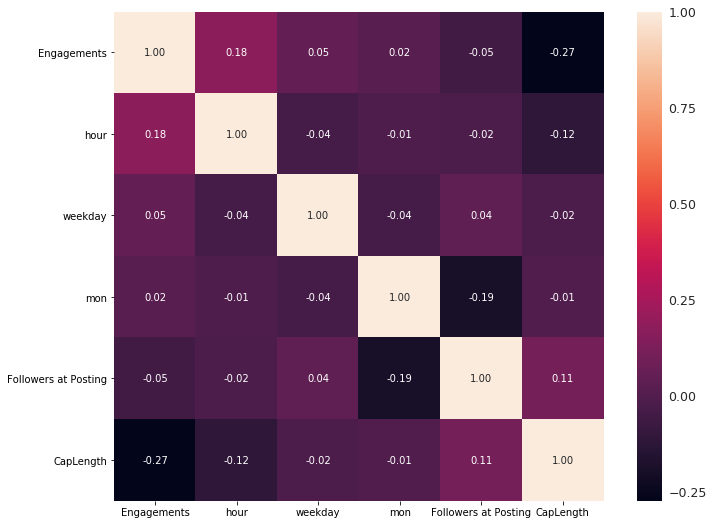

In [14]:
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Engagements')['Engagements'].index
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [15]:
def feature_selection(dataset, features, categorical_features):
    
    # filter features
    data = dataset[features]
    
    # categorical columns
    data = pd.get_dummies(data=data, columns=categorical_features)
    
    return data

In [16]:
features = ['Engagements','Followers at Posting', 'Type','weekend','mon','timeOfDay','CapLength','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']
categorical_features = ['Type','weekend','timeOfDay','mon','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']

In [17]:
train_features = feature_selection(train, features, categorical_features)

In [18]:
train_features.head()

,Engagements,Followers at Posting,CapLength,Type_Album,Type_Photo,Type_Video,weekend_N,weekend_Y,timeOfDay_Afternoon,timeOfDay_Evening,...,top25to30Team_0,top25to30Team_1,at_0,at_1,hash_0,hash_1,natlTV_0,natlTV_1,event_0,event_1
0,502093,36984682,95.0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,1,0,1,0
1,603380,36984682,64.0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,0,1,1,0
2,603380,36984682,46.0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,1,0,1,0
3,725100,36984682,43.0,0,0,1,1,0,0,0,...,1,0,1,0,1,0,0,1,1,0
4,661446,36984682,57.0,0,0,1,1,0,0,0,...,1,0,0,1,1,0,0,1,1,0


In [19]:
# split  data into features and array of response variable: engagements
def split_data(dataset, response_column = 'Engagements'):
    
    features = dataset.loc[:, dataset.columns != response_column]
    response = dataset[response_column]
    
    return features, response

In [20]:
features, response = split_data(train_features)

## XGBoost


In [21]:
# Split train test 
X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=132)

#### random model

In [22]:
import xgboost

# Naive Xgboost with random parameters
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=132) 

In [23]:
# fit model
model.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, importance_type='gain',
       learning_rate=0.07, max_delta_step=0, max_depth=3,
       min_child_weight=1.5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=132,
       silent=True, subsample=0.6)

##### training MAPE and R^2

In [32]:
pred = model.predict(X_train)
# calculate MAPE
np.mean(np.abs((y_train - pred) / y_train)) * 100

6.553096560053491

In [33]:
#calculate R2
r2_score(y_train, pred)

0.9130965142930166

##### testing MAPE and R^2

In [34]:
pred = model.predict(X_test)
# calculate MAPE
np.mean(np.abs((y_test - pred) / y_test)) * 100

7.580052400595363

In [35]:
#calculate R2
r2_score(y_test, pred) # overfitted 

0.8828398935981514

##### Feature Importance

In [24]:
sorted(model.get_booster().get_score(importance_type='gain').items(),key = lambda x: x[1],reverse = True)[:10]

[('Type_Video', 1580110001705.249),
 ('Type_Album', 926819186279.7727),
 ('Type_Photo', 850563033137.8195),
 ('at_0', 204078336998.8095),
 ('at_1', 156862190311.48236),
 ('mon_7', 152034248775.66037),
 ('top10to15Team_1', 81667279324.49275),
 ('popPlayer_0', 72201798580.48398),
 ('top25to30Team_0', 69056210482.67606),
 ('popPlayer_1', 65773140608.53557)]

### Tuning

Note: Tuning takes hours to run. We have commented the block out to avoid accidentally running the tuning.

In [69]:
# #for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[100,300,500,700,1000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
# }

                    
# xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=132)

# gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing,cv =10,
#                         n_jobs=4,iid=False, verbose=100,scoring='neg_mean_squared_error')
# gsearch1.fit(X_train,y_train)
# print (gsearch1.grid_scores_)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)



Fitting 10 folds for each of 12960 candidates, totalling 129600 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).


[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   19.3s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   19.4s

Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   19.4s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  29 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  30 tasks      | elapsed:   32.2s
[Parallel(n_jobs=4)]: Done  31 tasks      | elapsed:   32.2s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  45 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done  46 tasks      | elapsed:   42.3s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:   55.4s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  61 tasks      | elapsed:   57.9s
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:  1.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  78 tasks      | elapsed:  1.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:  1.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done  93 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  94 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  95 tasks      | elapsed:  1.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype

Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 108 tasks      | elapsed:  1.5min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=i

Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 124 tasks      | elapsed:  1.7min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 125 tasks      | elapsed:  1.7min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 

[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:  1.9min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 141 tasks      | elapsed:  1.9min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:  2.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 157 tasks      | elapsed:  2.1min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

[Parallel(n_jobs=4)]: Done 172 tasks      | elapsed:  2.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.3min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).[Parallel(n_jobs=4)]: Done 174 tasks      | elapsed:  2.3min

Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickli

Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5590,), dtype=int32).
Pickling array (shape=(622,), dtype=int32).
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:  2.5min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=i

[Parallel(n_jobs=4)]: Done 204 tasks      | elapsed:  3.0min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(5591,), dtype=int32).
Pickling array (shape=(621,), dtype=int32).
[Parallel(n_jobs=4)]: Done 205 tasks      | elapsed:  3.2min
Pickling array (shape=(45,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(2, 6212), dtype=int64).
Pickling array (shape=(43, 6212), dtype=uint8).
Pickling array (shape=(2,), dtype=object).
Pickling array (shape=(43,), dtype=object).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=(6212,), dtype=int64).
Pickling array (shape=

KeyboardInterrupt: 

### Best Model with parameters based on CV

In [37]:
# best model based on last tuning run
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.7,
                 gamma=1,                 
                 learning_rate=0.03,
                 max_depth=5,
                 min_child_weight=2,
                 n_estimators=700,                                                                    
                 reg_alpha=0.5,
                 reg_lambda=0.5,
                 subsample=0.8,
                 seed=132)
best_xgb_model.fit(X_train,y_train)

c:\users\jd cook\anaconda3\envs\nba\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:25:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=2, missing=None, n_estimators=700,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=1, seed=132,
             silent=None, subsample=0.8, verbosity=1)

In [38]:
pred = best_xgb_model.predict(X_train)
# calculate MAPE
print('MAPE: %s'%(np.mean(np.abs((y_train - pred) / y_train)) * 100))
#calculate R2
print('train r2: %s'%(r2_score(y_train, pred)))

pred = best_xgb_model.predict(X_test)
# calculate MAPE
print('test MAPE: %s'%(np.mean(np.abs((y_test - pred) / y_test)) * 100))
#calculate R2
print('test r2: %s'%(r2_score(y_test, pred)))

MAPE: 5.74058232793261
train r2: 0.9290331038892036
test MAPE: 7.3269522429783285
test r2: 0.8851588614819379


In [39]:
sorted(best_xgb_model.get_booster().get_score(importance_type='gain').items(),key = lambda x: x[1],reverse = True)

[('Type_Video', 2699143564880.3906),
 ('Type_Album', 967948173523.0132),
 ('Type_Photo', 819384666038.2316),
 ('mon_7', 244567756155.15152),
 ('at_1', 121365375608.55943),
 ('at_0', 81474328889.26027),
 ('top10to15Team_1', 78971655925.71428),
 ('top15to20Team_1', 63571610673.026085),
 ('top10to15Team_0', 63233288201.61861),
 ('popPlayer_0', 54654481297.19503),
 ('mon_9', 50527047510.32609),
 ('popPlayer_1', 46495455058.11395),
 ('natlTV_1', 42925376714.93617),
 ('timeOfDay_Night', 42017944767.72889),
 ('top15to20Team_0', 41767543644.15094),
 ('mon_10', 40763349452.05442),
 ('mon_2', 39692455336.132744),
 ('top25to30Team_1', 38274230134.5946),
 ('top20to25Team_0', 38048599229.27473),
 ('mon_8', 37681142838.88325),
 ('mon_5', 35261435238.79661),
 ('mon_12', 34197309941.227722),
 ('top5to10Team_1', 34046773947.319443),
 ('top20to25Team_1', 30684117580.51948),
 ('weekend_N', 28233344555.61111),
 ('natlTV_0', 27927419433.904987),
 ('top25to30Team_0', 27014542521.577236),
 ('CapLength', 2370

# HOLDOUT SET

#### Build Features

In [64]:
holdout_original = pd.read_csv('holdout_set.csv',encoding = 'unicode_escape', parse_dates=True)
holdout_original.head()

,Engagements,Followers at Posting,Created,Type,Description
0,NaN,36984682,2019-05-22 00:31:55 EDT,Photo,The @raptors even up the Eastern Conference Fi...
1,NaN,36984682,2019-05-21 23:20:41 EDT,Photo,The @raptors even the Eastern Conference Final...
2,NaN,36984682,2019-05-21 21:18:51 EDT,Video,@sergeibaka keeps it alive for the @raptors! (...
3,NaN,36955156,2019-05-21 18:20:09 EDT,Video,???? The SUPERHUMAN HANDS of Giannis & Kawhi ?...
4,NaN,36955156,2019-05-21 15:04:31 EDT,Video,?? the @raptors & @bucks in transition! #NBABr...


In [51]:
features = ['Engagements','Followers at Posting', 'Type','weekend','mon','timeOfDay','CapLength','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']
categorical_features = ['Type','weekend','timeOfDay','mon','popPlayer','top5Team','top5to10Team','top10to15Team', 'top15to20Team', 'top20to25Team', 'top25to30Team','at','hash','natlTV','event']

In [65]:
holdout = lower_description(holdout_original)
holdout = create_features(holdout)
holdout_features = feature_selection(holdout, features, categorical_features)

In [58]:
holdout_features, holdout_response = split_data(holdout_features)

#### Make Predictions

In [60]:
predictions = best_xgb_model.predict(holdout_features)

#### Save Predictions

In [62]:
holdout_original["Engagements"] = predictions

In [63]:
holdout_original.to_csv("holdout_set_buckets-nu.csv")